# 2D image to 3D reconstruction


### 1. Install dependencies

In [7]:
# Dependencies installation

!pip install torch torchvision torchaudio
!pip install Pillow
!pip install transformers
!pip install open3d
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninst

In [30]:
# Importing libraries

import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
import numpy as np
import torch

# We are directly downloading a model from huggingface which will do the heavy lifting and we dont need to train our own model
from transformers import DPTImageProcessor, DPTForDepthEstimation


### 2. Loading model

In [31]:
# Loading Model

image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)


### 3. Loading the Image

In [32]:
# Loading the image

image = Image.open("Heart.jpg")


In [33]:
# Resizing the image

new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + diff
new_size = (new_width, new_height)
image = image.resize(new_size)



### 4. Preparing the image for the model

In [34]:
inputs = image_processor(images=image, return_tensors="pt")

### 5. Getting the prediction from the Model

In [35]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

### 6. Post-processing

In [36]:

pad= 2
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad, pad, image.width - pad, image.height - pad))


### 7. Visualization of the depth estimation

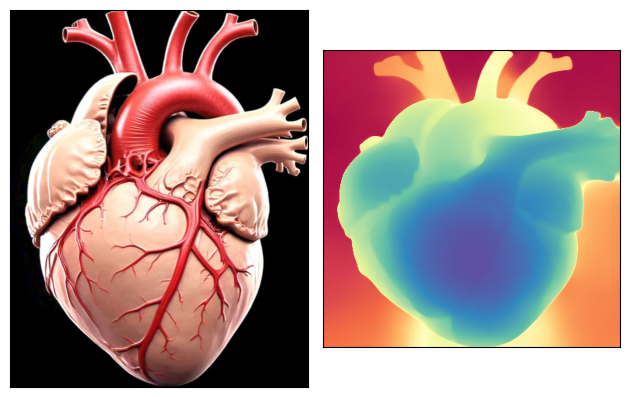

In [37]:

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].imshow(output, cmap= 'Spectral')
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)


### 8.  Preparing the depth image for open3d

In [38]:

width, height = image.size

depth_image = (output * 255 / np.max(output)).astype( 'uint8')

# Resizing depth_image to match color image dimensions
depth_image = Image.fromarray(depth_image).resize(image.size)
depth_image = np.array(depth_image)
image = np.array(image)

# create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d, convert_rgb_to_intensity=False)


### 9. Creating a Camera

In [39]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)


### 10. Creating Point Cloud and Post-processing

In [46]:
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

# the below snippet does not works on cloud platforms like google-colab
# but will give an output on local devices so there it can be used
# as I am running on google-colab I have commented it out.

#o3d.visualization.draw_geometries([pcd])

In [47]:
# outlier removal
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd_raw.select_by_index(ind)

In [49]:
# estimate normals

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

In [50]:
pcd_raw

PointCloud with 493520 points.

In [51]:
pcd

PointCloud with 482839 points.

So we can see that there are less points in pcd than pcd_raw that is because we did the post_processing and removed the outliers.

### 11. Saving the Point Cloud

In [52]:
import os

# Create output directory
output_dir = "pointclouds"
os.makedirs(output_dir, exist_ok=True)

# Define file path
pcd_file = os.path.join(output_dir, "heartpcd.ply")

# Save the point cloud so that we can see it in any pointcloud viewer
o3d.io.write_point_cloud(pcd_file, pcd)

print(f"Point cloud saved to: {pcd_file}")

Point cloud saved to: pointclouds/heartpcd.ply


### 12. 3D Point Cloud to Mesh i.e. Surface Reconstruction

In [54]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]

# Rotate the mesh

rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))

# the below code directly opens the visualization window which is
# not supported on cloud platforms thus is commented out but can
# be used on a local device.

#o3d.visualization.draw_geometries([mesh])

TriangleMesh with 763322 points and 1528501 triangles.

### 13. Saving the mesh

In [56]:
# Create output directory
output_dir = "mesh"
os.makedirs(output_dir, exist_ok=True)

# Define file path
# The mesh file could have been saved as .ply and many other methods
# Using .obj just for checking out different format than .ply.
# Although .ply is far better than .obj in my experience.
mesh_file = os.path.join(output_dir, "heartmesh.obj")

# Save the mesh so that we can see it in any mesh viewer
o3d.io.write_triangle_mesh(mesh_file, mesh)

print(f"Mesh file saved to: {mesh_file}")

[Open3D WARNING] Write Ply clamped color value to valid range
Mesh file saved to: mesh/heartmesh.ply
